In [1]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [2]:
!pip install tensorflow_decision_forests
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [7]:
train_file_path = "sample_data/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (17000, 9)


In [8]:
dataset_df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0


count     17000.000000
mean     207300.912353
std      115983.764387
min       14999.000000
25%      119400.000000
50%      180400.000000
75%      265000.000000
max      500001.000000
Name: median_house_value, dtype: float64


<ipython-input-13-83743a7ffa23>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['median_house_value'], color='g', bins=100, hist_kws={'alpha': 0.4});


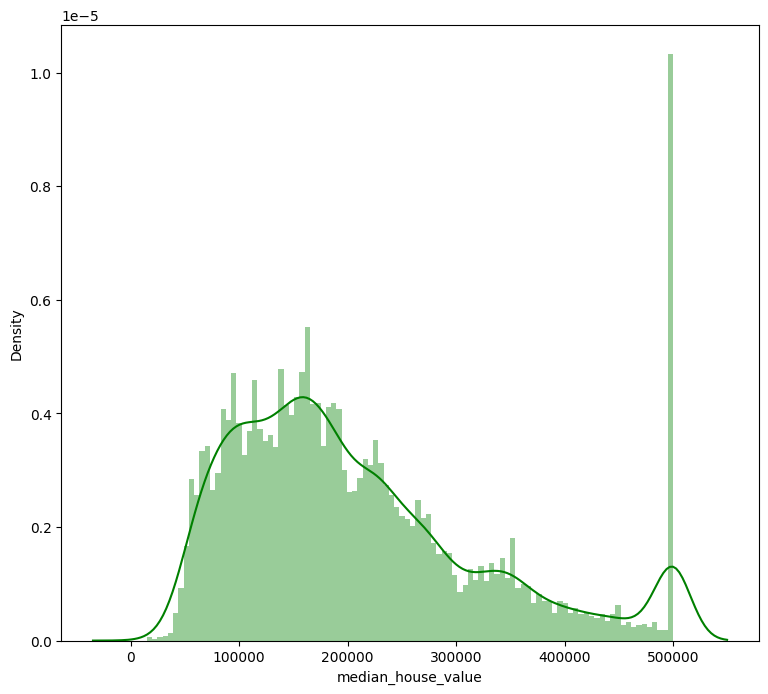

In [13]:
print(dataset_df['median_house_value'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['median_house_value'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [15]:
list(set(dataset_df.dtypes.tolist()))
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


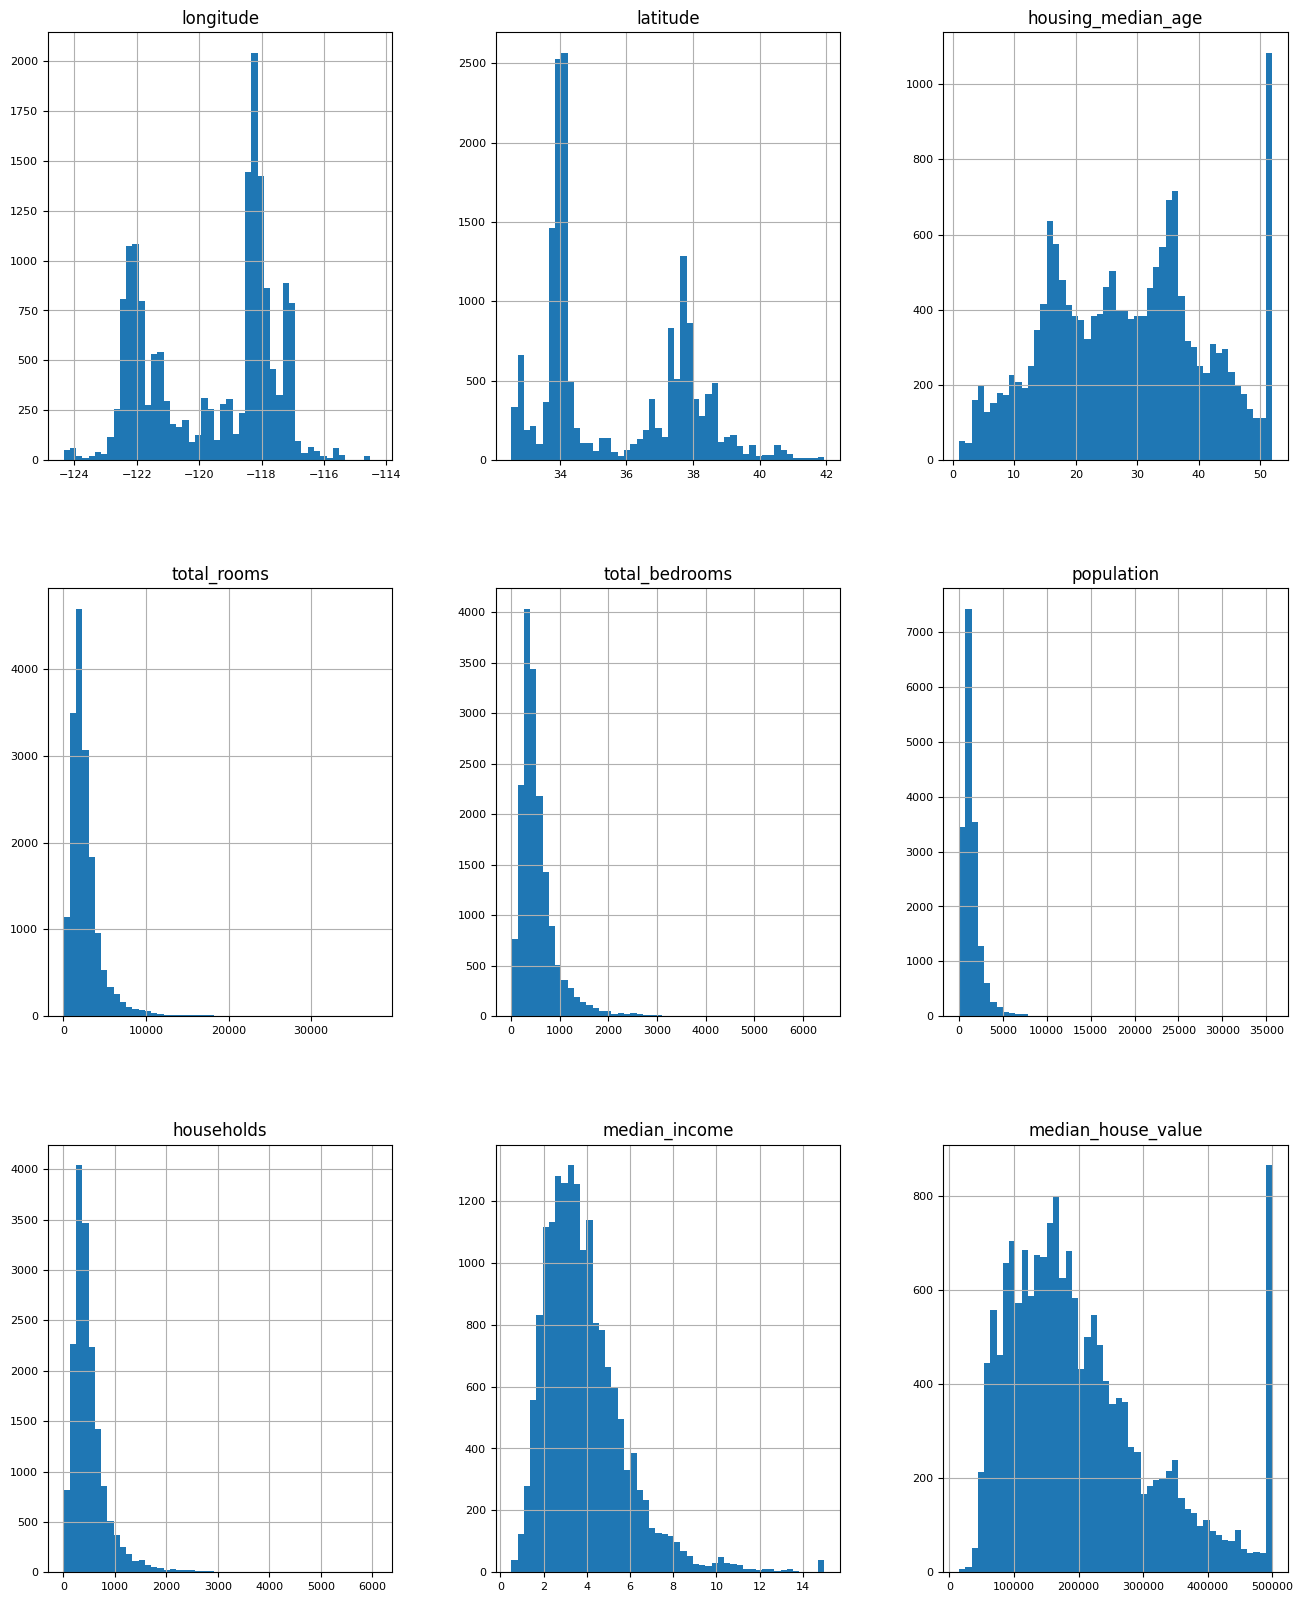

In [16]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [17]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

12021 examples in training, 4979 examples in testing.


In [19]:
label = 'median_house_value'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [20]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [21]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpt159doc_ as temporary training directory


In [22]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmp3ahnpfx6 as temporary training directory


In [23]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.720620. Found 12021 examples.
Training model...
Model trained in 0:00:12.794682
Compiling model...
Model compiled.


In [24]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

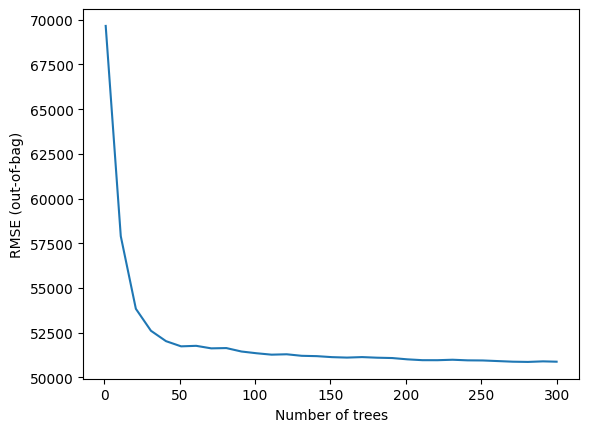

In [25]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [26]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=12021, accuracy=None, loss=None, rmse=50878.47109980638, ndcg=None, aucs=None, auuc=None, qini=None)

In [27]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

5/5 [==============================] - 1s 85ms/step - loss: 0.0000e+00 - mse: 2488779776.0000
loss: 0.0000
mse: 2488779776.0000


In [28]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [29]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("median_income" (1; #5), 154.0),
 ("latitude" (1; #3), 79.0),
 ("longitude" (1; #4), 42.0),
 ("total_rooms" (1; #8), 19.0),
 ("housing_median_age" (1; #2), 6.0)]

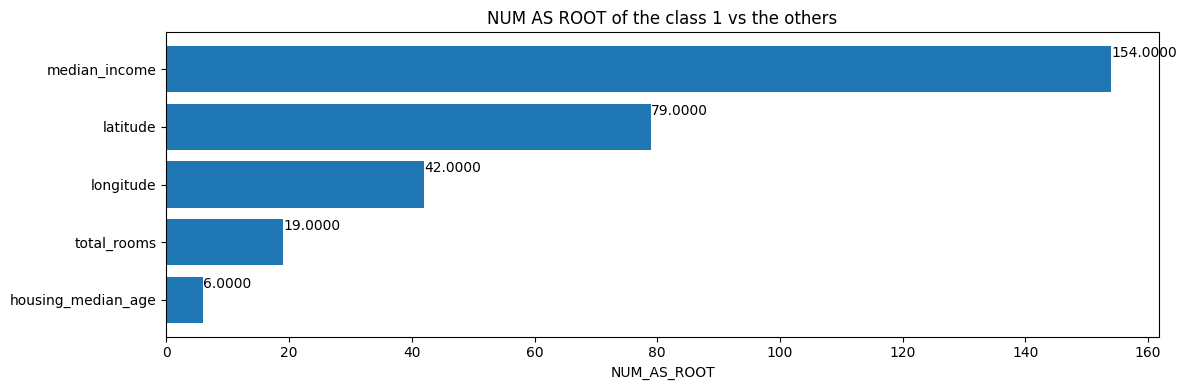

In [30]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [34]:
test_file_path = "sample_data/test.csv"
test_data = pd.read_csv(test_file_path)
test_data["Id"] = test_data.index
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'median_house_value': preds.squeeze()})

output.head()

3/3 [==============================] - 1s 218ms/step


,Id,median_house_value
0,0,397852.84375
1,1,211141.75000
2,2,262232.03125
3,3,309271.37500
4,4,79554.15625


In [39]:
predictions = rf.predict(test_ds)
predictions_df = pd.DataFrame({'predictions': predictions.squeeze()}) # index will be created automatically
predictions_df.head()

3/3 [==============================] - 0s 63ms/step


,predictions
0,397852.84375
1,211141.75000
2,262232.03125
3,309271.37500
4,79554.15625


In [41]:
predictions_df.to_csv('predictions.csv', index=False)
sample_submission_df.head()

""
